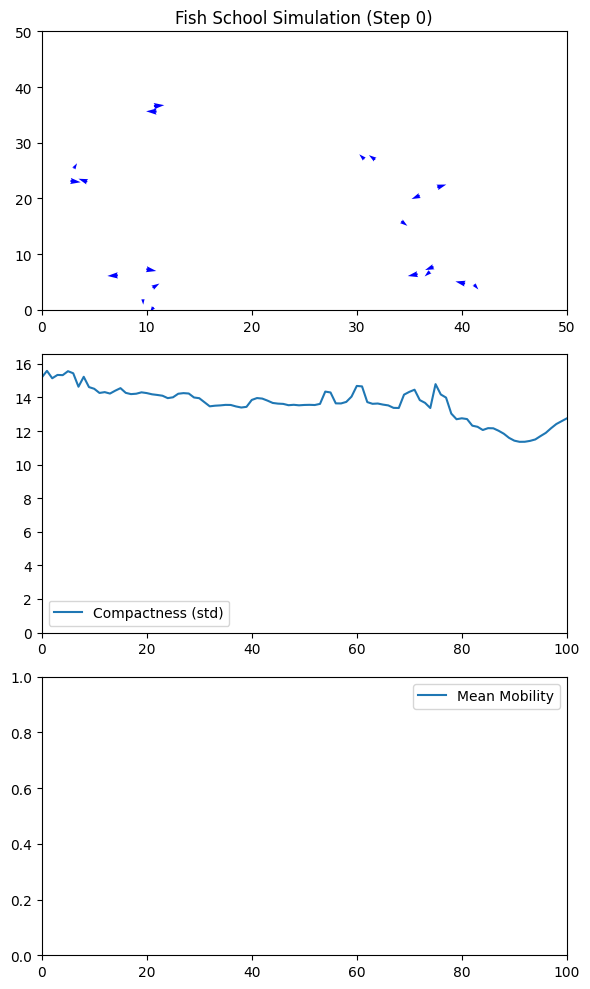

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# --- 选项 ---
SHOW_ANIMATION = True   # True=播放动画，False=只画曲线
N = 20       # 鱼数量
steps = 100  # 总步数
L = 50.0     # 空间大小
D1 = 0.5     # 回避距离
D2 = 2.0     # 接近距离
RC = 5.0     # 感知半径
SD1 = np.deg2rad(20)
SD2 = np.deg2rad(10)
K, theta = 2.0, 0.6  # Gamma 分布速度

# --- 初始化 ---
pos = np.random.rand(N, 2) * L
heading = np.random.uniform(0, 2*np.pi, N)
trajectories = np.zeros((steps, N, 2))
compactness_list = []
mobility_list = np.zeros(N)

# --- 模拟一步 ---
def simulate_step(frame):
    global pos, heading, mobility_list
    new_heading = heading.copy()

    for i in range(N):
        diffs = pos - pos[i]
        dists = np.linalg.norm(diffs, axis=1)
        mask = (dists > 0) & (dists < RC)
        neighbors = np.where(mask)[0]

        if len(neighbors) > 0:
            j = neighbors[np.argmin(dists[neighbors])]
            dist = dists[j]
            dir_to = np.arctan2(diffs[j,1], diffs[j,0])

            if dist < D1:  # 回避
                cand = dir_to + np.pi/2
                new_heading[i] = np.random.normal(cand, SD1)
            elif dist < D2:  # 平行定向
                cand = heading[j]
                new_heading[i] = np.random.normal(cand, SD2)
            else:  # 接近
                cand = dir_to
                new_heading[i] = np.random.normal(cand, SD1)
        else:
            new_heading[i] = np.random.uniform(0, 2*np.pi)

    heading[:] = new_heading
    speeds = np.random.gamma(K, theta, N)

    # 更新位置
    pos[:,0] = (pos[:,0] + np.cos(heading) * speeds) % L
    pos[:,1] = (pos[:,1] + np.sin(heading) * speeds) % L

    # 保存轨迹
    trajectories[frame] = pos

    # --- 指标 ---
    compactness = np.mean([np.std(pos[:,0]), np.std(pos[:,1])])
    compactness_list.append(compactness)

    for i in range(N):
        dists = np.linalg.norm(trajectories[:frame+1,i] - trajectories[0,i], axis=1)
        mobility_list[i] = np.max(dists)

# --- 动画更新函数 ---
def update(frame):
    simulate_step(frame)

    ax1.clear()
    ax1.set_xlim(0, L)
    ax1.set_ylim(0, L)
    ax1.set_title(f"Fish School Simulation (Step {frame})")
    ax1.quiver(pos[:,0], pos[:,1], np.cos(heading), np.sin(heading),
               angles="xy", scale_units="xy", scale=1, color="blue")

    ax2.clear()
    ax2.plot(compactness_list, label="Compactness (std)")
    ax2.set_xlim(0, steps)
    ax2.set_ylim(0, max(compactness_list)+1)
    ax2.legend()

    ax3.clear()
    ax3.plot([np.mean(mobility_list[:i+1]) for i in range(frame+1)], label="Mean Mobility")
    ax3.set_xlim(0, steps)
    ax3.set_ylim(0, np.max(mobility_list)+1)
    ax3.legend()

    plt.tight_layout()

# --- 主程序 ---
if SHOW_ANIMATION:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,10))
    ani = FuncAnimation(fig, update, frames=steps, interval=200, blit=False)
    display(HTML(ani.to_jshtml()))  # 在 Jupyter/Colab 中播放
else:
    # 跑完整个实验，不显示动画
    for t in range(steps):
        simulate_step(t)

    fig, (ax2, ax3) = plt.subplots(2, 1, figsize=(6,6))
    ax2.plot(compactness_list, label="Compactness (std)")
    ax2.set_title("Compactness over time")
    ax2.legend()

    ax3.plot([np.mean(mobility_list[:i+1]) for i in range(steps)], label="Mean Mobility")
    ax3.set_title("Mobility over time")
    ax3.legend()

    plt.tight_layout()
    plt.show()
